<img align="right" src="https://zenodo.org/record/7742997/files/Tops_Badge_Nasa.png" width="180" alt="NASA TOPS Logo">

# **Mapping Wildfire Burned Areas Using VIIRS/AVIRIS-3 Data (Python)**

Author [David Fonseca](https://www.linkedin.com/in/david-fonseca2/)

In this lesson, you will learn to access, preprocess, and analyze AVIRIS-3 data to map burned areas from the Palisades Fire in Los Angeles. Using satellite imagery obtained through the VIIRS tool, you will examine pre- and post-fire conditions, assess the fireâ€™s impact on vegetation and infrastructure.



### Learning Objectives
By the end of this lesson, you should be able to:
- **Access and download AVIRIS-3** and **VIIRS Burn Area data** for wildfire analysis.
- **Preprocess and clean AVIRIS-3 spectral radiance data** for visualization.
- **Compare pre- and post-fire imagery** to assess vegetation and burned area changes.
- **Overlay VIIRS Burn Area data** with **AVIRIS-3 images** using **GIS tools** to map burned areas.
- **Evaluate wildfire impact** by analyzing the overlap of burn data with **infrastructure** (e.g., buildings, population, critical infrastructure).
- **Quantify damage** and **assess risk** to urban zones and infrastructure.

### Introduction
Wildfires are one of the most devastating natural disasters, affecting ecosystems, wildlife, and human settlements. The Palisades Fire, which ignited on January 6, 2025, in the Los Angeles area, is a recent example of a wildfire that spread rapidly, impacting both natural environments and urban infrastructure. In this lesson, we will use AVIRIS-3 satellite imagery, accessed via the VIIRS tool, and VIIRS burn area data to analyze the fireâ€™s effects.

By comparing pre-fire and post-fire imagery, we will evaluate how vegetation changed and overlay this information with infrastructure data to assess the damage. This exercise will help you understand how remote sensing can support wildfire monitoring and risk analysis.

#### Palisades Fire Overview
The Palisades Fire affected large parts of the Los Angeles region, particularly residential areas and natural vegetation. Satellite imagery from AVIRIS-3 and VIIRS provides us with valuable data to assess the extent of the fire's impact. By overlaying burn area data with infrastructure maps, we can determine how much of the urban and natural landscapes were affected. The data allows us to quantify the impact and identify areas at high risk.

## 1. Accessing Wildfire Data
### Understanding AVIRIS-3 Data
AVIRIS-3 provides high-resolution hyperspectral imagery across a wide range of wavelengths, allowing for detailed analysis of land surface properties.

In [2]:
import os
import earthaccess
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.interpolate import griddata
from osgeo import gdal, osr

# Authenticate with NASA Earthdata (you need an account)
Auth = earthaccess.login()
# Search for VIIRS Burned Area data
viirs_data = earthaccess.search_data(
    short_name="AV3_L1B_RDN_2356", 
    temporal=('2025-01-16', '2025-01-16'),  # Palisades's wildfire (January 6 - January 17 2025)
    bounding_box=(-118.8, 33.9, -118.46, 34.28)  # Bounding box for Palisades California
)

print(f"Found {len(viirs_data)} files.")

Found 31 files.


![Alt text](../images/earthdata-search.png)

## 2. Processing and Visualizing Satellite Images

In [51]:
# Extract RDN.nc file URLs from VIIRS data
granule_urls = [
    [file_url for file_url in file.data_links() if file_url.endswith('RDN.nc')]
    for file in viirs_data[-1:]
]

for granule in granule_urls:
    # Download files
    earthaccess.download(granule, '../data/granule_files')
            
print("Processing complete for all granules.")

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Processing complete for all granules.


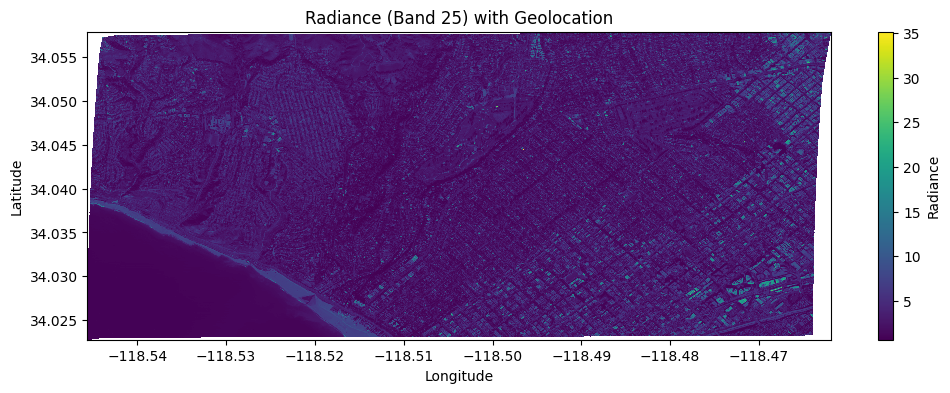

In [ ]:
# Plot first granule - Frist Flight

file_path = "../data/granule_files/AV320250116t193840_005_L1B_RDN_3f4aef90_RDN.nc"

# Open the file and plot radiance with geolocation
with h5py.File(file_path, 'r') as f:
    radiance = f['radiance']['radiance']
    lat = f['lat'][:]
    lon = f['lon'][:]
    
    # Take a specific band (like band 25)
    data = radiance[25, :, :]
    
    # Create cell edges
    lon_edges = (lon[:-1, :-1] + lon[1:, 1:]) / 2
    lat_edges = (lat[:-1, :-1] + lat[1:, 1:]) / 2
    
    # Sort to fix the monotonic issue
    lon_edges = np.sort(lon_edges, axis=1)
    lat_edges = np.sort(lat_edges, axis=0)

    plt.figure(figsize=(12, 4))
    plt.pcolormesh(lon_edges, lat_edges, data[:-1, :-1], shading='auto', cmap='viridis')
    plt.colorbar(label='Radiance')
    plt.title('Radiance (Band 25) with Geolocation')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

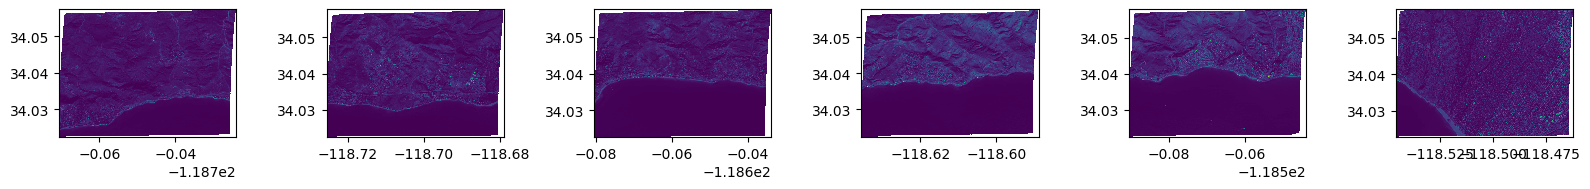

In [ ]:
# Plot first bacth of granules - First Flight
granule_paths = glob.glob('../data/*/*40_*RDN.nc')

fig, axes = plt.subplots(1, 6, figsize=(16, 2))  # 1 row, 6 columns

for i, path in enumerate(granule_paths):
    with h5py.File(path, 'r') as f:
        radiance = f['radiance']['radiance']
        lat = f['lat'][:]
        lon = f['lon'][:]
        data = radiance[25, :, :]
        lon_edges = (lon[:-1, :-1] + lon[1:, 1:]) / 2
        lat_edges = (lat[:-1, :-1] + lat[1:, 1:]) / 2
        lon_edges = np.sort(lon_edges, axis=1)
        lat_edges = np.sort(lat_edges, axis=0)
        pcm = axes[i].pcolormesh(lon_edges, lat_edges, data[:-1, :-1], shading='auto', cmap='viridis')
plt.tight_layout()
plt.show()

--> Flight: 44, File 1 out of 7
--> Flight: 44, File 1 out of 7
--> Flight: 44, File 1 out of 7
--> Flight: 44, File 1 out of 7
--> Flight: 44, File 1 out of 7
--> Flight: 44, File 1 out of 7
--> Flight: 44, File 1 out of 7


C:\Users\daysi\AppData\Local\Temp\ipykernel_22536\2770423018.py:57: RuntimeWarning: Mean of empty slice
  merged_radiance = np.nanmean(merged_radiance_list, axis=0)


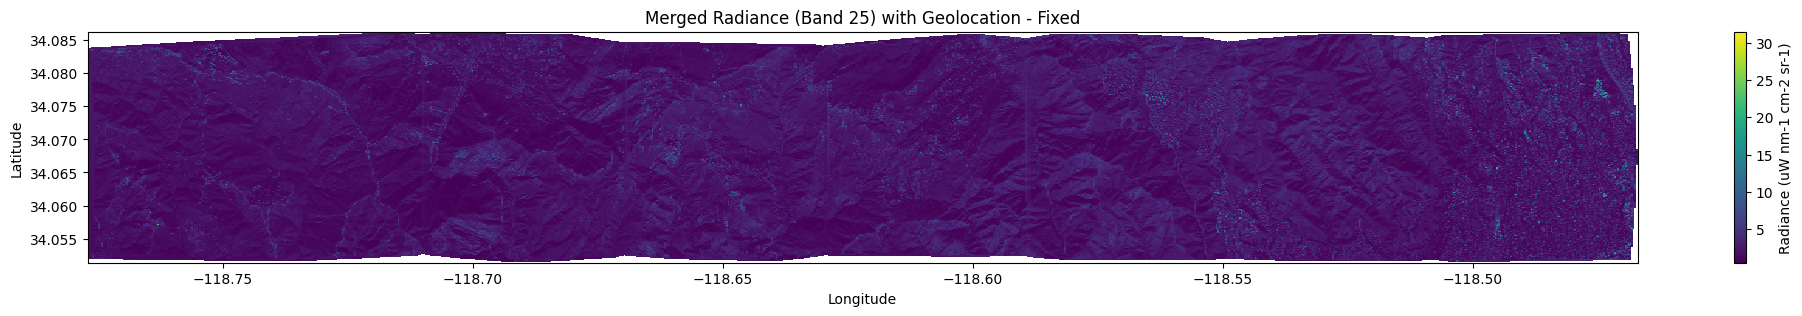

âœ… GeoTIFF saved to: ../data/merged_radiance_44.tif
--> Flight: 54, File 1 out of 8
--> Flight: 54, File 1 out of 8
--> Flight: 54, File 1 out of 8
--> Flight: 54, File 1 out of 8
--> Flight: 54, File 1 out of 8
--> Flight: 54, File 1 out of 8
--> Flight: 54, File 1 out of 8
--> Flight: 54, File 1 out of 8


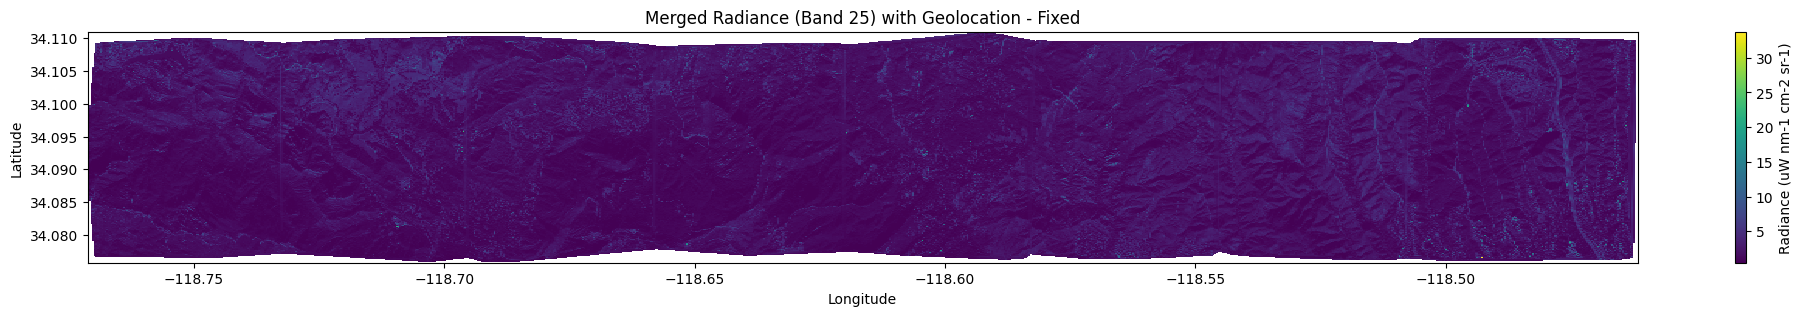

âœ… GeoTIFF saved to: ../data/merged_radiance_54.tif
--> Flight: 22, File 1 out of 4
--> Flight: 22, File 1 out of 4
--> Flight: 22, File 1 out of 4
--> Flight: 22, File 1 out of 4


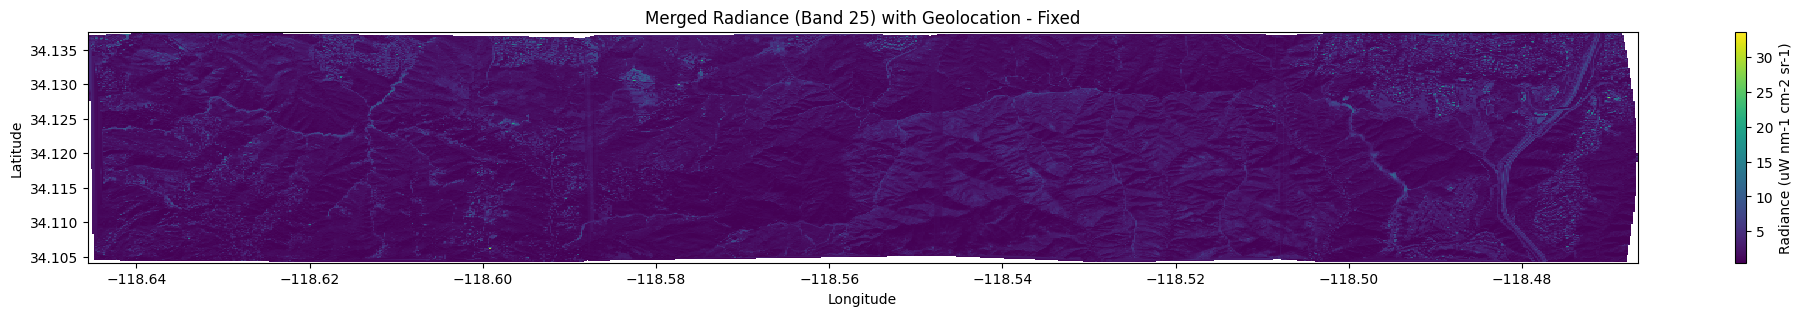

âœ… GeoTIFF saved to: ../data/merged_radiance_22.tif


In [59]:
flights = ['44', '54', '22']

for flight in flights:
    # List of file paths (ordered west to east)
    file_paths = sorted(glob.glob(f'../data/granule_files/*{flight}_*RDN.nc'))

    # Band to extract
    band = 25

    # Define resolution for the common grid
    num_points = 1000

    # Initialize common grid bounds
    lon_min, lon_max = float('inf'), float('-inf')
    lat_min, lat_max = float('inf'), float('-inf')

    # First loop to define grid bounds
    for file_path in file_paths:
        with h5py.File(file_path, 'r') as f:
            lat = f['lat'][:]
            lon = f['lon'][:]
            lon_min = min(lon_min, lon.min())
            lon_max = max(lon_max, lon.max())
            lat_min = min(lat_min, lat.min())
            lat_max = max(lat_max, lat.max())

    # Create common grid
    grid_lon = np.linspace(lon_min, lon_max, num_points)
    grid_lat = np.linspace(lat_min, lat_max, num_points)
    grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

    # Initialize container for merged data
    merged_radiance_list = []

    file = 1
    # Second loop to process each granule and interpolate to the grid
    for file_path in file_paths:
        print(f'--> Flight: {flight}, File {file} out of {len(file_paths)}')
        with h5py.File(file_path, 'r') as f:
            radiance = f['radiance']['radiance'][band, :, :]
            lat = f['lat'][:]
            lon = f['lon'][:]
            
            # Flatten arrays for interpolation
            points = np.array([lon.flatten(), lat.flatten()]).T
            radiance_flat = radiance.flatten()
            
            # Interpolate to common grid
            interpolated_radiance = griddata(
                points, radiance_flat, (grid_lon, grid_lat), method='linear'
            )
            
            # Store result for averaging
            merged_radiance_list.append(interpolated_radiance)

    # Average the overlapping areas across all granules
    merged_radiance = np.nanmean(merged_radiance_list, axis=0)

    # Plot the merged result
    plt.figure(figsize=(25, 3))
    plt.pcolormesh(grid_lon, grid_lat, merged_radiance, shading='auto', cmap='viridis')
    plt.colorbar(label='Radiance (uW nm-1 cm-2 sr-1)')
    plt.title(f'Merged Radiance (Band {band}) with Geolocation - Fixed')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

    # Output file path
    output_file = f'../data/merged_radiance_{flight}.tif'

    # Create a new GeoTIFF file
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = merged_radiance.shape
    dataset = driver.Create(output_file, cols, rows, 1, gdal.GDT_Float32)

    # Set geotransform and projection
    xmin, xmax = grid_lon.min(), grid_lon.max()
    ymin, ymax = grid_lat.min(), grid_lat.max()
    xres = (xmax - xmin) / cols
    yres = (ymax - ymin) / rows

    geotransform = (xmin, xres, 0, ymax, 0, -yres)
    dataset.SetGeoTransform(geotransform)

    # Set projection to WGS84
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)  # WGS84
    dataset.SetProjection(srs.ExportToWkt())

    # Write data to the file
    dataset.GetRasterBand(1).WriteArray(merged_radiance)
    dataset.GetRasterBand(1).SetNoDataValue(np.nan)

    # Close the dataset
    dataset = None

    print(f"âœ… GeoTIFF saved to: {output_file}")

## 4. Assessing Impact

ðŸš€ Processing file: ../data/granule_files/flight1/AV320250116t193840_003_L1B_RDN_3f4aef90_RDN.nc


C:\Users\daysi\AppData\Local\Temp\ipykernel_30644\1761167277.py:27: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = axes[0].pcolormesh(lon_edges, lat_edges, data[:-1, :-1], shading='auto', cmap='viridis')
C:\Users\daysi\AppData\Local\Temp\ipykernel_30644\1761167277.py:49: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = axes[1].pcolormesh(lon_edges, lat_edges, nbr[:-1, :-1], shading='auto', cmap='RdYlBu_r', vmin=-1, vmax=1)


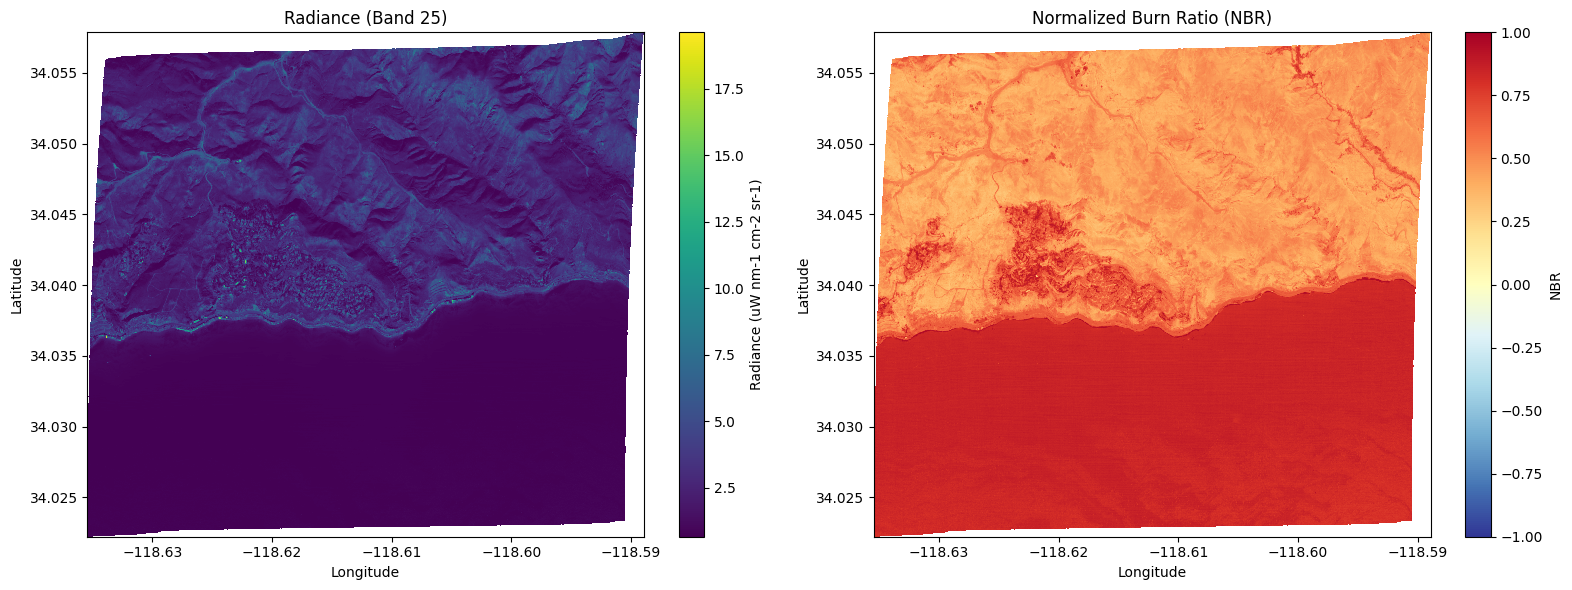

In [10]:
# âœ… Path to single granule file
file_path = '../data/granule_files/flight1/AV320250116t193840_003_L1B_RDN_3f4aef90_RDN.nc'

print(f"ðŸš€ Processing file: {file_path}")

# âœ… Open the file and read data
with h5py.File(file_path, 'r') as f:
    # âœ… Radiance data
    radiance = f['radiance']['radiance']
    lat = f['lat'][:]
    lon = f['lon'][:]

    # âœ… Take a specific band (like band 25)
    data = radiance[25, :, :]
    
    # âœ… Create cell edges for proper alignment
    lon_edges = (lon[:-1, :-1] + lon[1:, 1:]) / 2
    lat_edges = (lat[:-1, :-1] + lat[1:, 1:]) / 2

    # âœ… Sort to fix the monotonic issue
    lon_edges = np.sort(lon_edges, axis=1)
    lat_edges = np.sort(lat_edges, axis=0)

    # âœ… Plot radiance
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    pcm = axes[0].pcolormesh(lon_edges, lat_edges, data[:-1, :-1], shading='auto', cmap='viridis')
    fig.colorbar(pcm, ax=axes[0], label='Radiance (uW nm-1 cm-2 sr-1)')
    axes[0].set_title('Radiance (Band 25)')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')

    # âœ… Choose NIR and SWIR bands
    # NIR â‰ˆ 858.6 nm â†’ Band 63  
    # SWIR â‰ˆ 2205.2 nm â†’ Band 181  
    nir_band = radiance[63, :, :]
    swir_band = radiance[181, :, :]

    # âœ… Compute NBR
    nbr = (nir_band - swir_band) / (nir_band + swir_band)

    # âœ… Mask out invalid values
    nbr = np.ma.masked_invalid(nbr)

    # âœ… Clip NBR values to between -1 and 1
    nbr = np.clip(nbr, -1, 1)

    # âœ… Plot NBR
    pcm = axes[1].pcolormesh(lon_edges, lat_edges, nbr[:-1, :-1], shading='auto', cmap='RdYlBu_r', vmin=-1, vmax=1)
    fig.colorbar(pcm, ax=axes[1], label='NBR')
    axes[1].set_title('Normalized Burn Ratio (NBR)')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')

# âœ… Show all plots
plt.tight_layout()
plt.show()

### Radiance (Band 25) Interpretation
- The left image shows the radiance in the near-infrared (NIR) spectrum, which highlights vegetation and surface reflectance.
- In healthy, undisturbed vegetation, NIR reflectance tends to be **higher** because of the internal leaf structure.
- Burned or damaged areas typically show **reduced NIR reflectance** since the leaf structure is destroyed or altered.


### Normalized Burn Ratio (NBR) Interpretation
- The NBR image (right) measures fire severity by comparing the difference between NIR (healthy vegetation) and SWIR (sensitive to moisture loss and charring).  
  - High NBR values (close to **+1**, shown in **red**) indicate **healthy vegetation**.
  - Low NBR values (close to **-1**, shown in **blue**) indicate **burned or damaged areas**.

#### Evidence of Fire Impact in NBR:
- Large patches of **light red/orange** color over the coastal and mountainous areas indicate **healthy vegetation**.
- However, the areas closer to the coastline and lowlands show **lower NBR values** (closer to **0 or negative**), suggesting:
    - Loss of vegetation
    - Scorched or charred areas  
    - Fire impact on the ground cover and tree canopy
- The **smooth red area** along the coast suggests widespread burn scars or barren ground post-fire. 

### Key Findings:
- The fire's **most severe damage** seems to be concentrated along the lower coastal and urban-adjacent regions, where NBR values are lowest.  
- The higher, more rugged inland terrain shows less fire damage, consistent with the tendency of fires to spread more rapidly in low-lying dry areas.  
- The radiance data confirms a reduction in NIR reflectance in the areas showing low NBR, consistent with fire-induced vegetation loss.  
- The transition from low (red) to high (yellow) NBR values inland suggests a **patchy burn pattern**, where some areas were spared due to moisture or natural firebreaks. 

## 5. Conclusion
The analysis of radiance and NBR data from the Palisades fire area indicates significant burn damage in the central and northern regions. The low NBR values in these areas confirm the presence of scorched and barren land, consistent with post-fire effects. The southern and coastal regions show higher NBR values, suggesting healthy vegetation and lower fire impact. This analysis demonstrates the effectiveness of hyperspectral remote sensing in identifying and quantifying fire damage. Further analysis could improve understanding of vegetation recovery and long-term environmental impact.
- The Palisades Fire caused **moderate to severe vegetation loss** along the coastal and urban-facing regions.
- Higher elevations and mountainous terrain were less affected.
- The fire left behind a visible burn scar, with lower vegetation recovery in the most intensely burned areas.


